#   Rock Paper Scissors - Proyect

In [1]:
__author__ = "Jorge Aliaga Luque"
__website__ = "https://jorgealiaga36.github.io/jorge-aliaga-luque/"

The main goal of this proyect is to `build a image classification model for the rock, paper and scissors game`. 

First I prepare the data using generators for image augmentation. Then, I use a pretained model called `Inception-v3` and I add some extra layers to fit the model for the application. For training the model we I the Rock Paper Scissors Dataset and then, the model is evaluated using unseen images.

Inception-v3 weights link: https://www.kaggle.com/datasets/keras/inceptionv3

### Dataset description

The `Rock Paper Scissors Dataset` contains images from various hands, from different races, ages, and genders, posed into rock, paper or scissors and labeled as such. The images were created using CGI techniques as an experiment in determining if a model trained on a CGI-based dataset could classify real images.

Dataset link: 
https://www.kaggle.com/datasets/sanikamal/rock-paper-scissors-dataset

## Table of Contents

- [**1. Dataset review**](#ap1)

    - 1.1. [Defining dataset path](#ap1_1)
    - 1.2. [Exploring images](#ap1_2)
    


- [**2. Data preparation**](#ap2)

    - 2.1. [Image augmentation](#ap2_1)
    - 2.2. [Data generators](#ap2_2)
    
    

- [**3. Building the model**](#ap3)

    - 3.1. [Inception-v3 pretrained model](#ap3_1)
    - 3.2. [New top layers](#ap3_2)
    - 3.3. [Test the model](#ap3_3)
    
    
    
- [**4. Model evaluation**](#ap4)

    - 4.1. [Accuracy](#ap4_1)
    - 4.2. [Loss function](#ap4_2)
    
    
     
- [**5. Testing the model**](#ap5)

    - 5.1. [Predictions](#ap5_1)

### Importing libraries

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import os
import random

import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.simplefilter(action='ignore', category=(FutureWarning, UserWarning))

sns.set_style('darkgrid')

In [28]:
import tensorflow as tf
from keras.preprocessing.image import ImageDataGenerator
from keras.utils import load_img, img_to_array
from keras.applications.inception_v3 import InceptionV3, preprocess_input
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Flatten
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint

print(tf.__version__)

2.10.0


<a name="ap1"></a>
# 1. Dataset review

<a name="ap1_1"></a>
## 1.1. Defining dataset path

In [4]:
train_dir = 'datasets/rock-paper-scissors/train/'
val_dir =  'datasets/rock-paper-scissors/validation/'
test_dir =  'datasets/rock-paper-scissors/test/' 

Let's see how many samples we have in the dataset:

In [5]:
train_samples = len(os.listdir(train_dir + 'scissors')) + len(os.listdir(train_dir + 'rock')) + len(os.listdir(train_dir + 'paper')) 
val_samples = train_samples = len(os.listdir(val_dir + 'scissors')) + len(os.listdir(val_dir + 'rock')) + len(os.listdir(val_dir + 'paper')) 
test_samples = len(os.listdir(test_dir))
                   
print('Train samples: {}'.format(train_samples))
print('Validation samples: {}'.format(val_samples))
print('Test samples: {}\n'.format(test_samples))
print('Total amount of samples: {}'.format(train_samples + test_samples + test_samples))

Train samples: 372
Validation samples: 372
Test samples: 33

Total amount of samples: 438


<a name="ap1_2"></a>
## 1.2. Exploring images

We have images corresponding to three classes: rock, paper and scissors. Let's plot some from the training set:

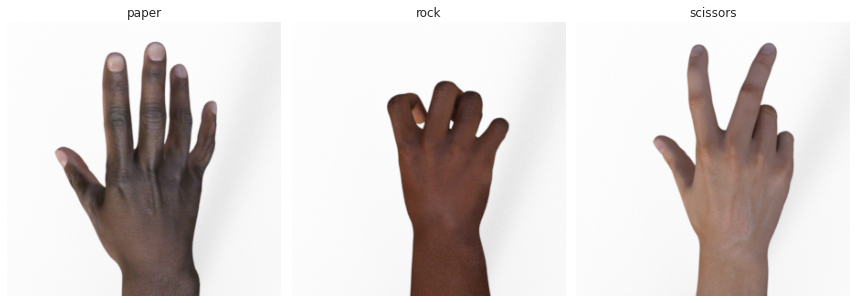

Image size: (300, 300, 3)



In [6]:
index = 0

plt.figure(figsize=(12, 10))

for img_type in ['paper', 'rock', 'scissors']:
    sample =  random.choice(os.listdir(train_dir + img_type))
    image = load_img(train_dir + img_type + '/' + sample)
    plt.subplot(1, 3, index+1)
    plt.imshow(image)
    plt.title(img_type)
    plt.axis('Off')

    index+=1

plt.tight_layout()
plt.show()

image = load_img(train_dir + 'rock/' + random.choice(os.listdir(train_dir + 'rock')))
IMAGE_SIZE = img_to_array(image).shape
                                
print('Image size: {}\n'.format(IMAGE_SIZE))

<a name="ap2"></a>
# 2. Data preparation

<a name="ap2_1"></a>
## 2.1. Image augmentation

Data Augmentation allows to generate images with modifications to the original ones. The model will learn from these variations (changing angle, size and position), being able to predict better never seen images that could have the same variations.

We apply the following randomly variations for the training set:

+ 40° range rotations.
+ Shifting image width by 20%.
+ Shifting image height by 20%.
+ Rotation across X-axis by 20%.
+ Image zooming by 20%.
+ Flip inputs horizontally.

All images (train and validation) are scaled between 1-255.

In [7]:
train_datagen = ImageDataGenerator(
      rescale=1./255,
      rotation_range=40,
      width_shift_range=0.2,
      height_shift_range=0.2,
      shear_range=0.2,
      zoom_range=0.2,
      horizontal_flip=True,
      fill_mode='nearest')

val_datagen = ImageDataGenerator(rescale=1./255)

<a name="ap2_2"></a>
## 2.2. Data generators

We must define the batch size for train and validation sets.

In [8]:
batch_size_train = 100
batch_size_val = 50

RGB images resized to 150x150 pixels. Labels are encoded as a categorical vector.

In [9]:
train_generator = train_datagen.flow_from_directory(
        train_dir,
        target_size=(150, 150),
        batch_size=batch_size_train,
        class_mode='categorical')

val_generator = val_datagen.flow_from_directory(
        val_dir,
        target_size=(150, 150),
        batch_size=batch_size_val,
        class_mode='categorical')

Found 2520 images belonging to 3 classes.
Found 372 images belonging to 3 classes.


As we can see the number of train images have been aumented.

<a name="ap3"></a>
# 3. Building the model

To achieve a better performance on our model, we use a pre-trained model: Inception-v3. This is called transfer learning and for that we leverage the trained layers of an existing model and then adding new layers to it.

Inception-v3 is a convolutional neural network for assisting in image analysis and object detection, and got its start as a module for Googlenet. It is the third edition of Google's Inception Convolutional Neural Network, originally introduced during the ImageNet Recognition Challenge

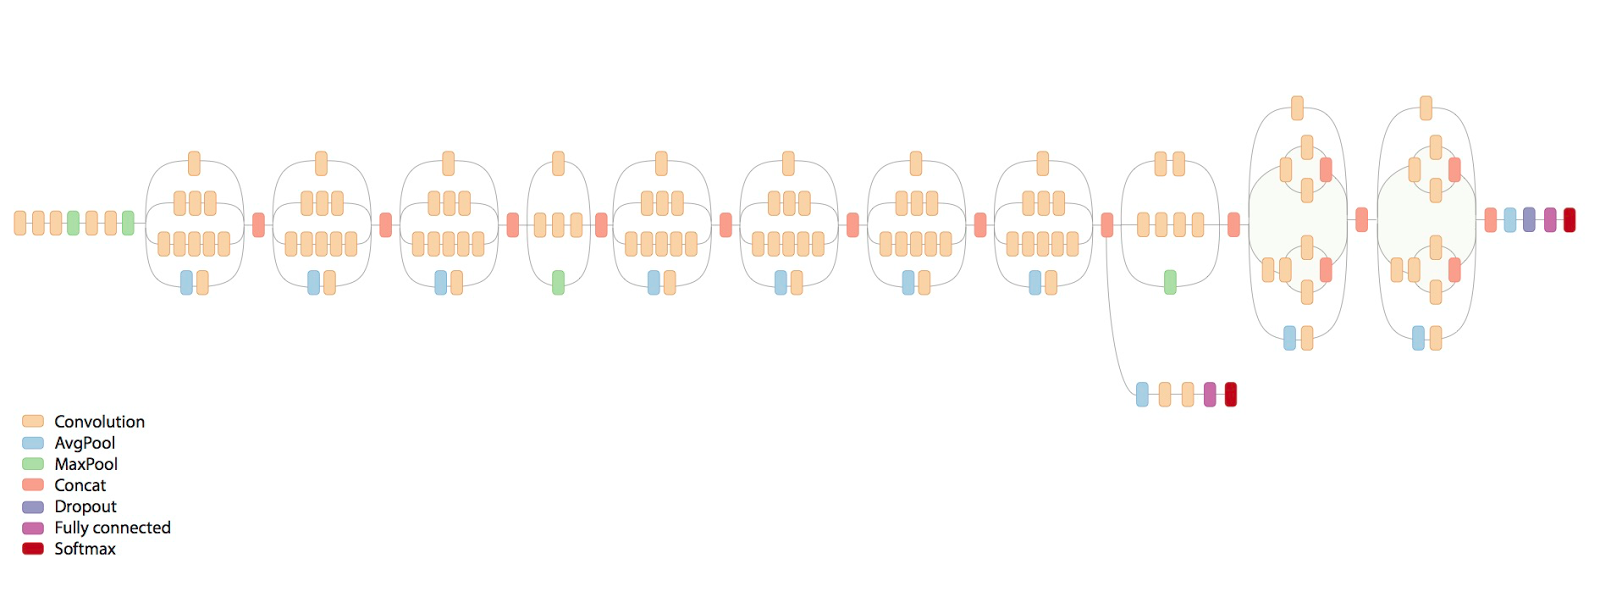

<a name="ap3_1"></a>
## 3.1. Inception-v3 pretrained model

First we download the pre-trained model weights: 

In [10]:
weights_dir = 'datasets/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5'

Then we remove the fully-connected layer at the top. We use only the convolution layers of the Inception-v3 architecture. The input shape is set to 150x150x3.

In [27]:
pretrained_model = InceptionV3(weights=weights_dir,
                               include_top=False,
                               input_shape=((150, 150, 3)))

We load the weights into our base model and we freeze the convolution layers to take advantage of the features it has learned already.

In [12]:
pretrained_model.load_weights(weights_dir)

for layer in pretrained_model.layers: 
    layer.trainable=False

In [13]:
#pretrained_model.summary()

<a name="ap3_2"></a>
## 3.2. New top layers

We use up to `mixed_7`as our base model and we add dense leyers to it to fit the model better for our application.  This is because the original last layer might be too specialized in what it has learned so it might not translate well into our application. `mixed_7` on the other hand will be more generalized.

In [14]:
last_layer = pretrained_model.get_layer('mixed7')
last_output = last_layer.output

# Flatten the output layer to 1 dimension.
x = Flatten()(last_output)
# Fully connected layer with 1,024 hidden units and ReLU activation.
x = Dense(1024, activation='relu')(x)
#Dropout rate of 0.2.
x = Dropout(0.2)(x)
#Final sigmoid layer for classification.
x = Dense(3, activation='softmax')(x)

<a name="ap3_3"></a>
## 3.3. Train the model

We append the dense network to the base model. Then, we use `Adam` optimizer with `categorical_crossentrophy` loss function.

In [15]:
model = Model(pretrained_model.input, x)

model.compile(optimizer=Adam( learning_rate=0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

Also is neccesary to define a chekpointer. This time we use the `ModelCheckpoint`one to save a model or weights (in a checkpoint file) at some interval, so the model or weights can be loaded later to continue the training from the state saved.

In [16]:
checkpointer = ModelCheckpoint(filepath='datasets/weights_trained_model.hdf5',
                               verbose=1,
                               save_best_only=True)

We define the steps to take for every epoch and the number of epochs (the number of complete passes in the training dataset):

In [17]:
#n° images=batch_size*steps

train_steps_epoch = np.ceil(train_samples/batch_size_train)
val_steps_epoch = np.ceil(val_samples/batch_size_val)
num_epochs = 20

And finally, we train the model:

In [18]:
history = model.fit(train_generator,
                    validation_data=val_generator,
                    epochs=num_epochs,
                    steps_per_epoch=train_steps_epoch,
                    validation_steps=val_steps_epoch,
                    callbacks=[checkpointer],
                    verbose=1)

Epoch 1/20
4/4 [==============================] - ETA: 0s - loss: 8.6719 - accuracy: 0.4325
Epoch 1: val_loss improved from inf to 4.23711, saving model to datasets/weights_trained_model.hdf5
4/4 [==============================] - 32s 7s/step - loss: 8.6719 - accuracy: 0.4325 - val_loss: 4.2371 - val_accuracy: 0.4516
Epoch 2/20
4/4 [==============================] - ETA: 0s - loss: 1.7510 - accuracy: 0.7025
Epoch 2: val_loss improved from 4.23711 to 1.39551, saving model to datasets/weights_trained_model.hdf5
4/4 [==============================] - 22s 6s/step - loss: 1.7510 - accuracy: 0.7025 - val_loss: 1.3955 - val_accuracy: 0.6613
Epoch 3/20
4/4 [==============================] - ETA: 0s - loss: 0.9929 - accuracy: 0.7475
Epoch 3: val_loss improved from 1.39551 to 0.62138, saving model to datasets/weights_trained_model.hdf5
4/4 [==============================] - 20s 5s/step - loss: 0.9929 - accuracy: 0.7475 - val_loss: 0.6214 - val_accuracy: 0.7823
Epoch 4/20
4/4 [===================

<a name="ap4"></a>
# 4. Model evaluation

The best model got an accuracy over the validation data of ~ 99% so its performance on unseen data is very good!

In [19]:
max_acc = round(max(history.history['accuracy']), 4)
corresp_loss = round(min(history.history['loss']), 4)

print('Accuracy: {} %'.format(max_acc))
print('Loss: {}'.format(corresp_loss))

Accuracy: 0.9875 %
Loss: 0.0342


<a name="ap4_1"></a>
## 4.1. Accuracy

Plotting accuracy through epochs.

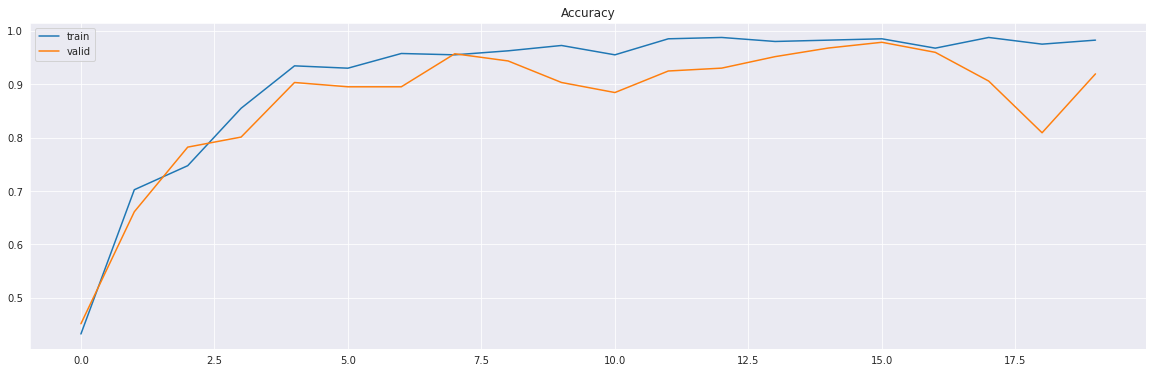

In [20]:
plt.figure(figsize=(20,6))

plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='valid')

plt.title('Accuracy')
plt.legend(loc='best')

plt.show()

<a name="ap4_2"></a>
## 4.2. Loss function

Plotting loss through apochs:

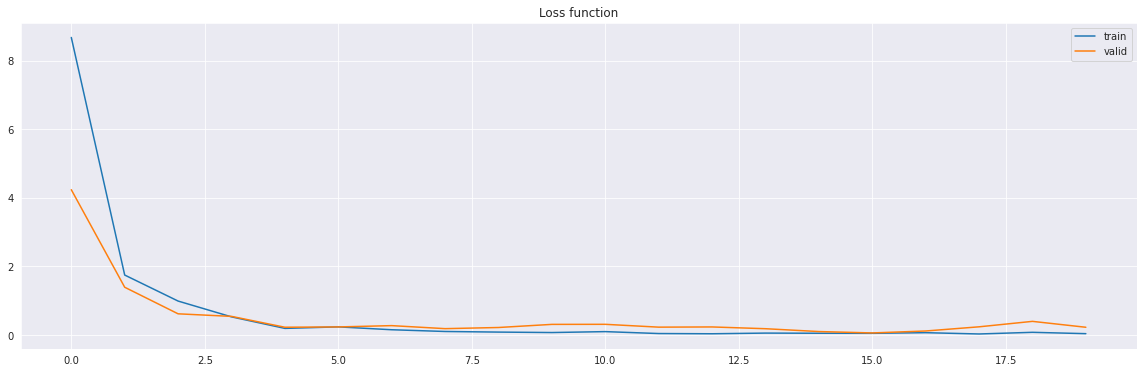

In [21]:
plt.figure(figsize=(20,6))

plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='valid')

plt.title('Loss function')
plt.legend(loc='best')

plt.show()

<a name="ap5"></a>
# 5. Testing the model

Let's see what are the model classes:

In [22]:
classes = []

class_map = train_generator.class_indices
for key in class_map.keys(): 
    classes.append(key)

print('Dataset classes:\n {}'.format(class_map))

Dataset classes:
 {'paper': 0, 'rock': 1, 'scissors': 2}


### Loading weights

We first load the weights of the trained model where we achieved better performance:

In [23]:
model.load_weights('datasets/weights_trained_model.hdf5')

### Test images

In [24]:
test_images = os.listdir(test_dir)
random.shuffle(test_images)

print('Test samples: {}\n\n{}'.format(test_samples, test_images))

Test samples: 33

['scissors3.png', 'paper7.png', 'paper1.png', 'rock-hires1.png', 'paper-hires1.png', 'rock7.png', 'rock3.png', 'paper6.png', 'paper-hires2.png', 'scissors5.png', 'scissors-hires1.png', 'rock6.png', 'scissors7.png', 'rock2.png', 'rock5.png', 'rock8.png', 'scissors6.png', 'scissors-hires2.png', 'scissors8.png', 'paper3.png', 'paper5.png', 'paper9.png', 'paper4.png', 'paper2.png', 'rock1.png', 'rock4.png', 'paper8.png', 'rock9.png', 'scissors2.png', 'scissors9.png', 'scissors1.png', 'rock-hires2.png', 'scissors4.png']


<a name="ap5_1"></a>
## 5.1. Predictions

We implement a function for preprocessing each image and return its corresponding class predicted:

In [25]:
def predict_image(img_dir):
    img = load_img(img_dir, target_size=(150,150))
    x = img_to_array(img)/255
    x = np.expand_dims(x, axis=0)
    
    probabilities = model.predict(x, verbose=0)
    class_predicted = np.argmax(probabilities) # 0: rock , 1: paper, 2: scissors.
    
    return img, class_predicted

Printing the model predictions:

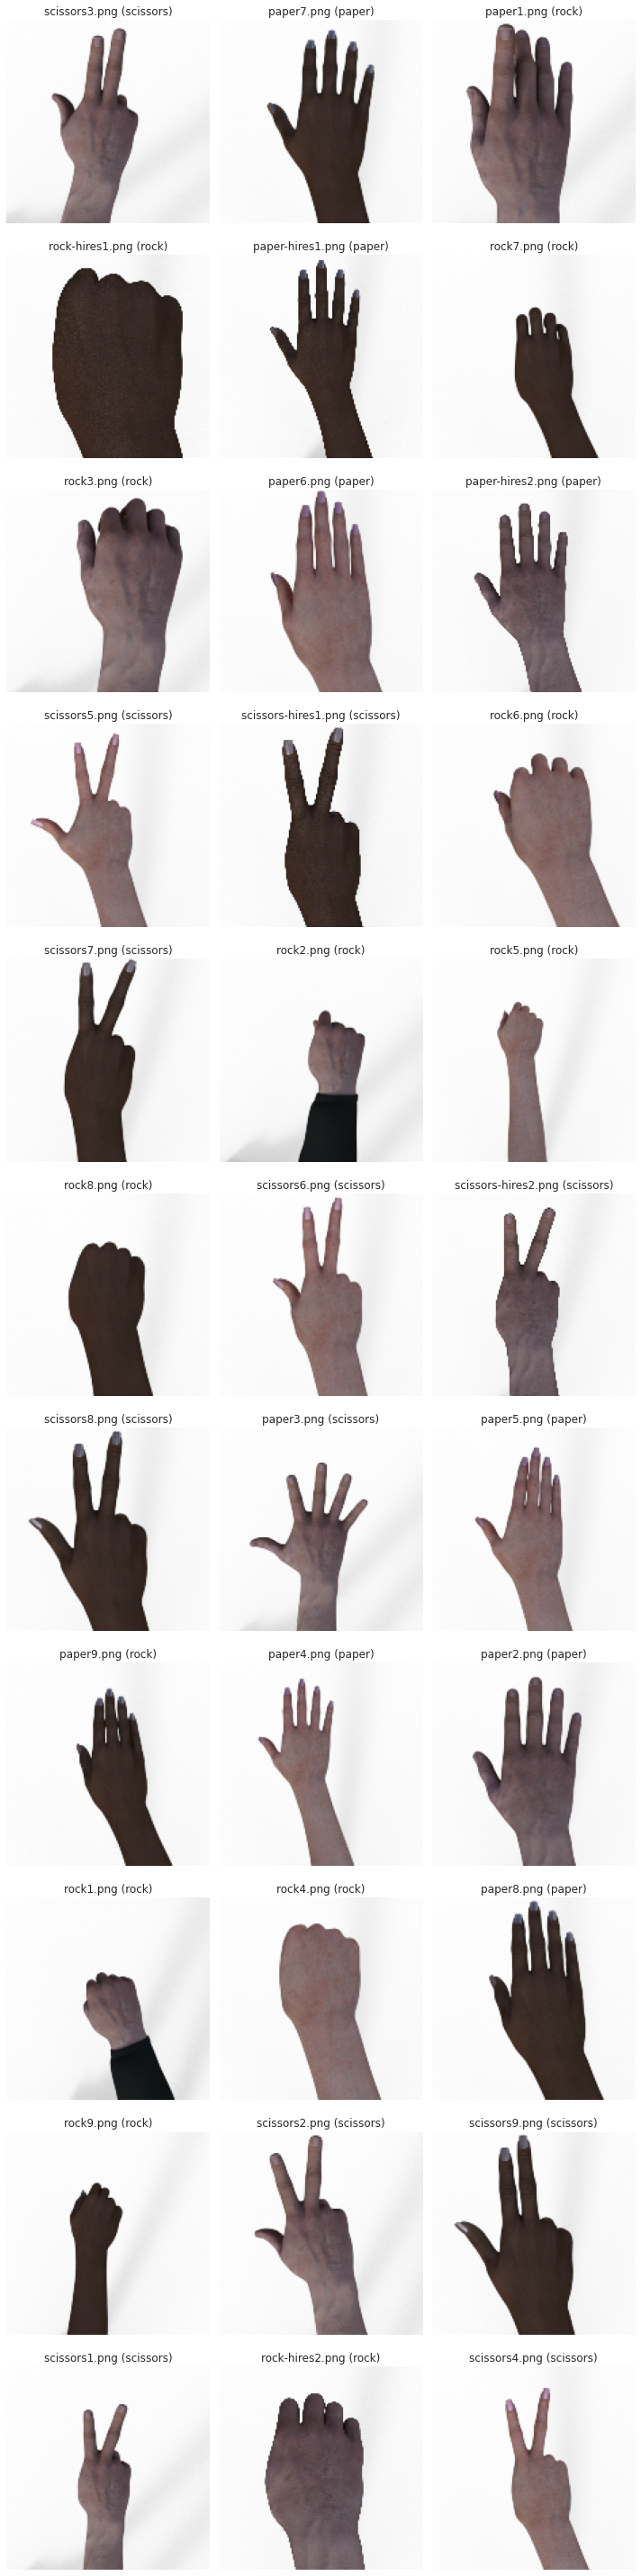

In [26]:
index = 0

plt.figure(figsize=(10, 40))

for sample in test_images:
    img, class_predicted = predict_image(test_dir + sample)
    plt.subplot(11, 3, index+1)
    plt.imshow(img)
    plt.title(sample + ' (' + str(classes[class_predicted]) +  ')')
    plt.axis('Off')

    index+=1

plt.tight_layout()
plt.show()

As we can see our model has predicted well every image in the test set. That is because we achieved ~99% accuracy (0.9875).